# DSA Final Project: Analyzing Angela Merkel's Speeches Using NLP

## Step 1: Setup

1.1 Load packages

In [ ]:
# Loading pyLDAvis and pandas at the same has caused some trouble for us. We need to install both modules individually and then re-start runtime respectively.

!pip install pyLDAvis

In [ ]:
!pip install pandas==1.3.1

In [ ]:
# Import re, numpy and panda for data wrangling
import re
import numpy as np
import pandas as pd
from pprint import pprint
from pandas import DataFrame
import tqdm

# Import NLTK and spacy for pre-processing text data
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
import en_core_web_sm

# Import Gensim for topic modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.test.utils 

# Import plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

1.2 Import data set

In [126]:
# Load Data
df = pd.read_csv("https://raw.githubusercontent.com/f-winkler/DSA_2021_FinalProject_Merkel/main/Merkel_english_speeches_v2.csv", sep=";")
df = df.drop('Column1', 1)

# Explore data set
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):  # more options can be specified also
    display(df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,doc_id,text,title,date,country,speaker,length,language
0,1,"Madam Speaker, Mr. Vice President, Distingui...",Speech by Federal Chancellor Angela Merkel bef...,03.11.2009,Germany,A.Merkel,3480,en
1,2,"Excellencies, Colleagues, Ladies and gentlem...",Speech by Federal Chancellor Angela Merkel at ...,25.01.2010,Germany,A.Merkel,3351,en
2,3,"President Hennessy, President Emeritus Casper...",Speech by Federal Chancellor Angela Merkel at ...,15.04.2010,Germany,A.Merkel,3570,en
3,4,"Ambassador, Excellencies, Ladies and gentlem...",Speech by Federal Chancellor Angela Merkel at ...,27.05.2010,Germany,A.Merkel,5241,en
4,5,"Ladies and gentlemen, On 9 November 1989, Gün...",Speech by Federal Chancellor Angela Merkel at ...,08.09.2010,Germany,A.Merkel,2621,en
...,...,...,...,...,...,...,...,...
115,116,"Director-General, dear Tedros Mr Ryan, Mr Schw...",Speech by Federal Chancellor Dr Angela Merkel ...,01.09.2021,Germany,A.Merkel,1704,en
116,117,"Your Majesty, Prime Minister, Pedro, President...",Speech by Federal Chancellor Dr Angela Merkel ...,14.10.2021,Germany,A.Merkel,2632,en
117,118,"Prime Minister Boris Johnson, Excellencies, ...",Speech by Federal Chancellor Dr Angela Merkel ...,01.11.2021,Germany,A.Merkel,465,en
118,119,"Mr President, Excellencies, Ladies and gentl...",Speech by Federal Chancellor Dr Angela Merkel ...,01.11.2021,Germany,A.Merkel,705,en


## Step 2: Pre-Processing Data

2.1 Prepare stopwords

In [128]:
# Set up our stopwords vector from NLTK
stop_words = stopwords.words('english')

# Add stopwords that we don't want to include in our topic modeling (through try and error, e.g. country was part of every topic and thus unimportant)
stop_words.extend(['want', 'must', 'also', 'need', 'many', 'make', 'take', 'takes', 'took', 'taken', 'say', 'see', 'would', 'well', 'country', 'countries', 'countrys', 'year', 'use', 'people', 'today', 'work', 'time', 'much', 'however', 'thank', 'german', 'germany', 'world'])

2.2 Tokenize words and remove punctuation

In [129]:
# Tokenize each sentence into a list of words, removing punctuations 
# Use Gensim's simple_preprocess() function and set deacc=True to remove punctuations

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text']))

2.3 Create bigram and trigram models

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

2.4 Remove stopwords, make bigrams and lemmatize words

In [131]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

# Remove stopwords
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Make bigrams and trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Lemmatize (turn words into their lemmas)
def lemmatization(texts, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [132]:
# Run the functions sequentially

# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = en_core_web_sm.load(disable = ['parser', 'ner'])

# Run lemmatization keeping only noun, adj, vb, adv
data_lemma = lemmatization(data_words_bigrams, 
                           allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


## Step 3: Topic Modeling

### Topic Modeler 1: Latent Dirichlet Allocation (LDA)

Still to do: 

*   Define topics, analyze, visualize...
*   Evaluate LDA model

3.1 Create the Dictionary and Corpus needed for LDA Modeling

In [135]:
# Create a dictionary (id2word) and a corpus which are the two main inputs to the LDA topic model

# Create Dictionary
id2word = corpora.Dictionary(data_lemma)

# Create Corpus
texts = data_lemma

# Create a document term matrix (term document frequency)
corpus = [id2word.doc2bow(text) for text in texts]

# Gensim creates a unique id for each word in the document. The produced corpus is a mapping of (word_id, word_frequency).

# If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
# id2word[10]

# Or, you can see a human-readable form of the corpus itself (term-frequency):
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

3.2 Build the LDA model

In [146]:
# For now, we have everything required to run the LDA model.
# In addition to the corpus and dictionary, we need to provide the number of topics as well.
# Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.
# chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word = id2word,
                                       num_topics = 8,
                                       random_state = 42,                                        
                                       chunksize = 100,
                                       passes = 10,                                   
                                       per_word_topics=True,
                                       minimum_probability = 0)


In [147]:
# Once the LDA model is trained, we can save and load the model object

# Save model in pickle format to working directory
lda_model.save("lda_merkel.pkl")

# Load model back into your workspace from working directory
lda_model = gensim.models.LdaModel.load("lda_merkel.pkl")

3.3 View the topics in the LDA model

In [148]:
# The LDA model is built with 5 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.
# We can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"important" + 0.006*"together" + 0.005*"global" + 0.005*"crisis" + '
  '0.005*"good" + 0.005*"development" + 0.005*"economic" + 0.004*"state" + '
  '0.004*"european" + 0.004*"health"'),
 (1,
  '0.016*"climate" + 0.009*"course" + 0.009*"therefore" + '
  '0.009*"international" + 0.008*"important" + 0.007*"way" + 0.007*"national" '
  '+ 0.007*"continue" + 0.006*"climate_protection" + 0.006*"goal"'),
 (2,
  '0.010*"partner" + 0.010*"agreement" + 0.010*"important" + '
  '0.008*"connection" + 0.008*"course" + 0.008*"value" + 0.007*"think" + '
  '0.007*"target" + 0.007*"trade" + 0.007*"remain"'),
 (3,
  '0.014*"state" + 0.010*"rule" + 0.010*"order" + 0.010*"therefore" + '
  '0.009*"value" + 0.008*"law" + 0.007*"able" + 0.007*"european" + '
  '0.006*"woman" + 0.006*"trust"'),
 (4,
  '0.010*"relation" + 0.010*"european" + 0.008*"global" + 0.007*"partner" + '
  '0.007*"important" + 0.006*"course" + 0.006*"issue" + 0.006*"policy" + '
  '0.005*"security" + 0.005*"internet"'),
 (5,
  

3.4 Identify topics from LDA keywords (human decision)

3.5 Compute model perplexity and coherence score

In [149]:
# Model perplexity and topic coherence provide a measure to judge how good a given topic model is.

# Compute model perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemma, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.701668547945384

Coherence Score:  0.3160395363705355


3.6 Visualize the topics-keywords from LDA model

In [150]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

# Each bubble on the left-hand side plot of pyLDAvis package’s interactive chart represents a topic. The larger the bubble, the more prevalent is that topic.
# A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
# A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
# If you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.002174 -0.034064       1        1  54.382139
5     -0.048565 -0.012387       2        1  19.416380
6      0.094492 -0.067703       3        1  16.837050
1      0.143226  0.053377       4        1   3.923081
4     -0.064977 -0.035061       5        1   1.781368
7      0.062482  0.131699       6        1   1.497714
2     -0.016982 -0.119102       7        1   1.335788
3     -0.171849  0.083240       8        1   0.826481, topic_info=               Term        Freq       Total Category  logprob  loglift
279       important  512.000000  512.000000  Default  30.0000  30.0000
519           state  327.000000  327.000000  Default  29.0000  29.0000
181        european  356.000000  356.000000  Default  28.0000  28.0000
696          course  411.000000  411.000000  Default  27.0000  27.0000
557       therefore  289.000000  289.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
296   international    3.872849  262.918466   Topic8  -5.2646   0.5779
182            even    3.752467  282.706472   Topic8  -5.2962   0.4738
279       important    3.716643  512.305946   Topic8  -5.3058  -0.1304
1090     especially    2.866374  138.406485   Topic8  -5.5655   0.9186
568        together    2.809177  450.714048   Topic8  -5.5857  -0.2822

[647 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
998       1  0.698602  abandon
998       6  0.261976  abandon
1         1  0.542898     able
1         2  0.183816     able
1         3  0.183816     able
...     ...       ...      ...
619       4  0.008398     year
619       5  0.011197     year
619       6  0.005599     year
619       7  0.011197     year
619       8  0.005599     year

[1521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 7, 2, 5, 8, 3, 4])

3.7 Model coherence analysis (finding the optimal LDA model specification)

In [151]:
# Our approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.
# The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [152]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemma, start=1, limit=10, step=1)

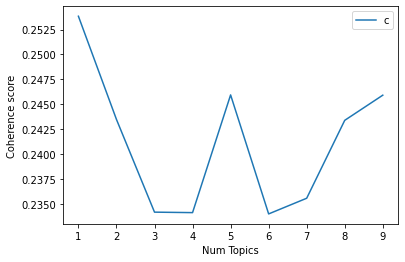

In [153]:
# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [154]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.2538
Num Topics = 2  has Coherence Value of 0.2435
Num Topics = 3  has Coherence Value of 0.2342
Num Topics = 4  has Coherence Value of 0.2341
Num Topics = 5  has Coherence Value of 0.2459
Num Topics = 6  has Coherence Value of 0.234
Num Topics = 7  has Coherence Value of 0.2356
Num Topics = 8  has Coherence Value of 0.2434
Num Topics = 9  has Coherence Value of 0.2459


##Topic modeler 2: Non-negative Matrix Factorization (NMF)

Still to do:
*   Fine-tune count vectorization: lemmatize if possible
*   Find the optimal number of topics for the NMF model



In [155]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from nltk.probability import FreqDist
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.cluster import DBSCAN
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

import seaborn as sns
# %matplotlib inline

3.1 Count vectorization

In [ ]:
# This optional step creates a sorted list of words and their frequency in all speeches combined (document term matrix).

df['Split'] = data_lemma
fr = FreqDist(df.Split[0])

for s in df.Split[1:]:
    frdist = FreqDist(s)
    fr.update(frdist)

def getKey(item):
    return item[1]
a = fr.items()
sorted(a, key = getKey, reverse=True)

In [157]:
# This is the code for the actual count vectorization (this is essentially a more sophisticated way of tokenizing text into words)

def remove_numbers(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

cv = CountVectorizer(stop_words=stop_words, max_df=1.0, min_df = 1, ngram_range = (1, 1), preprocessor = remove_numbers)
  # Here is where the fine-tuning happens (because it decides which words are kept in the NMF model). More arguments: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
  # "stop_words" argument removes our pre-defined stop words
  # "max_df" ignores terms that have a document frequency higher than this threshold (in this case, I use 1.0, i.e. 100%, that means we don't remove any words; but this could be lowered to remove very frequent words). Can either be a percentage value (between 0.0 and 1.0) or an integer as the number of frequency of a word
  # "min_df" ignores terms that have a document frequency lower than this threshold (in this case, I use 1, so no words are removed; but this could have a percentage value between 0.0 and 1.0 or an integer in terms of the frequency of a word)
  # "ngram_range" of (1, 2) would mean that unigrams and bigrams (words that frequenty occur together, e.g. European Union) are included as single tokens. For now, we only include unigrams.

doc_to_word = cv.fit_transform(df.text) # Adds the "text" column of the dataframe as an argument
X_t_cv  = cv.transform(df.text) # Adds the "text" column of the dataframe as an argument


3.2 Run the NMF model

In [158]:
nmf_model = NMF(10) # Choose number of topics here
doc_topic = nmf_model.fit_transform(doc_to_word)

topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3), 
             index = ["topic_1","topic_2", "topic_3","topic_4", "topic_5", 
                     "topic_6","topic_7", "topic_8","topic_9", "topic_10"
                     ],
             columns = cv.get_feature_names())
topic_word_nmf

# The table output shows all individual words as separate columns and their correlation with each of the topics.

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aachen,ab,ababa,abandon,abandoning,abandonment,abbas,abbreviated,abductions,abdul,abdullah,abdurrahim,abe,aberrations,abhorrent,abide,abiding,abilities,ability,abiy,abkhazia,ablaze,able,abolish,abolished,abolishing,abolition,abominable,abroad,absolute,absolutely,absorbing,abstract,absurdity,abundance,abundant,abundantly,abuse,abused,abuses,...,yields,yoke,yom,york,youll,young,younger,youre,youth,youths,youve,yozgat,ypres,yugoslav,yugoslavia,yuste,yves,yã¼cel,yã¼cels,zaev,zaldã,zations,zealand,zentrum,zero,zest,zhongli,zib,zone,zoran,zu,zuse,zürich,ángel,å¼ec,élysée,être,özüdoğru,şahin,şimşek
topic_1,0.060,0.000,0.005,0.008,0.025,0.010,0.024,0.000,0.000,0.043,0.000,0.000,0.000,0.002,0.000,0.003,0.000,0.000,0.078,0.016,0.000,0.000,0.662,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.116,0.001,0.000,0.002,0.000,0.000,0.014,0.047,0.000,0.000,...,0.000,0.000,0.001,0.000,0.000,0.000,0.009,0.000,0.000,0.007,0.000,0.000,0.003,0.022,0.033,0.000,0.000,0.009,0.009,0.077,0.000,0.000,0.000,0.005,0.000,0.000,0.001,0.005,0.013,0.054,0.000,0.005,0.000,0.000,0.000,0.024,0.000,0.000,0.000,0.000
topic_2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.219,0.000,0.022,0.000,0.000,0.000,0.000,0.000,0.040,0.000,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.022,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.013,0.032,0.013,0.013,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.000,0.000,0.047,0.001,0.000,0.000,0.000,0.012,0.000,0.000,0.000,0.000
topic_3,0.000,0.000,0.004,0.005,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000,0.484,0.000,0.000,0.000,0.000,0.000,0.031,0.014,0.099,0.015,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,...,0.029,0.000,0.000,0.070,0.000,0.010,0.002,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.003,0.002,0.000,0.000,0.000,0.029,0.000,0.000,0.000,0.022,0.000,0.000,0.000,0.019,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000
topic_4,0.000,0.000,0.000,0.014,0.000,0.000,0.016,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.056,0.000,0.000,0.000,0.000,0.177,0.000,0.000,0.000,0.000,0.000,0.027,0.000,0.096,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.039,...,0.017,0.000,0.000,0.004,0.000,0.127,0.000,0.000,0.065,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.006,0.000,0.000,0.021,0.006,0.013,0.000,0.000,0.006,0.000,0.028,0.000,0.000,0.008,0.000,0.008,0.000
topic_5,0.097,0.000,0.004,0.000,0.059,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.034,0.000,0.000,0.114,0.000,0.017,0.000,0.619,0.000,0.006,0.000,0.000,0.000,0.052,0.000,0.025,0.000,0.007,0.003,0.000,0.000,0.017,0.000,0.000,0.000,...,0.000,0.006,0.000,0.000,0.000,0.033,0.000,0.000,0.094,0.000,0.000,0.000,0.000,0.000,0.000,0.032,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.016,0.000,0.000,0.000,0.017,0.000,0.001,0.000,0.000,0.000,0.001,0.000
topic_6,0.000,0.032,0.002,0.027,0.000,0.000,0.017,0.000,0.000,0.000,0.000,0.018,0.000,0.004,0.044,0.000,0.020,0.006,0.043,0.000,0.000,0.020,0.406,0.005,0.006,0.032,0.000,0.020,0.093,0.031,0.018,0.000,0.021,0.004,0.023,0.000,0.012,0.088,0.031,0.004,...,0.000,0.006,0.016,0.030,0.000,0.367,0.025,0.000,0.141,0.004,0.000,0.035,0.004,0.000,0.000,0.007,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.015,0.054,0.011,0.001,0.015,0.000,0.000,0.000,0.015,0.000,0.000,0.011,0.000,0.017,0.018,0.000,0.035
topic_7,0.000,0.000,0.007,0.018,0.001,0.000,0.006,0.055,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.023,0.000,0.000,0.000,0.519,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,...,0.002,0.000,0.000,0.007,0.012,0.036,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.024,0.000,0.000,0.000,0.00

3.3 Display topics from NMF and their keywords

In [159]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix +1)
        else:
            print("\nTopic: '",topic_names[ix + 1],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [160]:
display_topics(nmf_model, cv.get_feature_names(), 10)


Topic  1
security, us, russia, united, nato, international, european, states, ukraine, cooperation

Topic  2
european, union, europe, member, economic, states, monetary, freedom, crisis, energy

Topic  3
climate, change, energy, emissions, agreement, global, us, protection, paris, new

Topic  4
china, economic, one, growth, crisis, us, euro, global, course, believe

Topic  5
europe, european, us, together, rights, council, presidency, eu, future, fundamental

Topic  6
freedom, us, one, internet, values, years, wall, together, berlin, every

Topic  7
health, one, development, global, important, international, diseases, course, us, therefore

Topic  8
africa, development, years, digital, african, still, us, means, like, one

Topic  9
region, development, one, security, qatar, future, important, another, state, education

Topic  10
labour, international, ilo, social, conditions, working, organization, one, women, workers


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


3.4 Display distribution of topics across years

In [161]:
# Add a new column for the year of the speech (only year, not the whole date)

df['date'] = pd.to_datetime(df['date']) # Converts "date" column to pandas datetime format
df['year'] = df['date'].dt.year # Creates new "year" column


In [162]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(2),
                             index = df.year.astype(int), 
                             columns = ["topic_1","topic_2", "topic_3","topic_4", "topic_5", 
                     "topic_6","topic_7", "topic_8","topic_9", "topic_10"
                     ])
dtn = doc_topic_nmf.groupby(doc_topic_nmf.index).sum()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(dtn)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
year,,,,,,,,,,
2009,0.61,0.00,0.27,0.36,0.94,4.90,0.00,0.00,0.00,0.00
2010,3.15,9.21,1.79,3.13,3.50,9.58,1.56,1.20,15.48,0.97
2011,6.78,2.49,0.94,13.80,3.11,8.84,1.41,3.21,10.67,7.85
2012,2.44,11.64,5.70,17.97,5.25,6.11,0.17,3.03,0.70,0.22
2013,1.35,2.81,0.53,4.18,1.03,1.26,0.26,1.02,2.66,0.32
2014,4.20,6.53,0.38,2.36,4.37,4.66,0.73,0.99,0.55,0.17
2015,7.43,1.62,8.70,1.50,6.93,2.01,6.42,1.57,3.35,5.04
2016,3.11,0.77,8.03,5.11,1.75,1.65,1.91,1.38,1.28,2.14
2017,5.55,5.35,7.69,3.48,1.76,3.73,14.41,10.22,3.08,3.82


3.5 Create heatmap to show the distribution of topics across years

Text(0.5, 1.0, 'Speech Topics Over The Years\n')

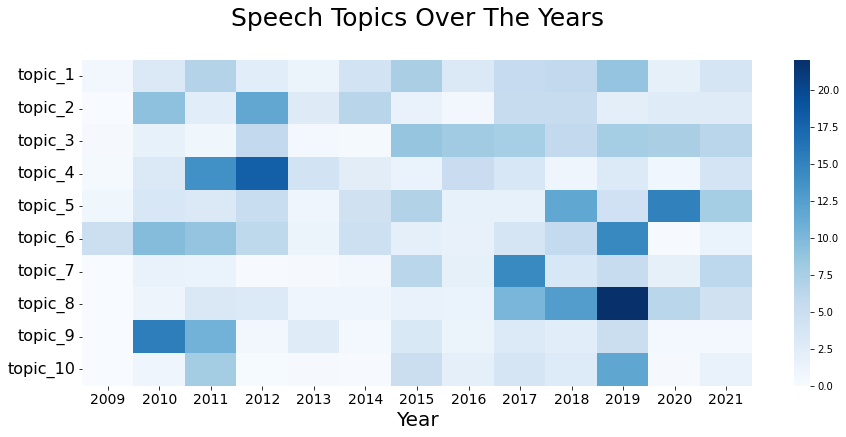

In [163]:
plt.figure(figsize = (15, 6))
sns.heatmap(dtn.T, annot=False, cbar=True, cmap="Blues")
plt.xlabel('Year', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 16)
plt.title('Speech Topics Over The Years\n', fontsize=25)

## Step 4: Sentiment Analysis

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import sentiment_analyzer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
def sentiment_analysis_old(text):
  score = SentimentIntensityAnalyzer().polarity_scores(text)
  print(score)

The results give us numerical values for use of negative, neutral, and positive word choice. The compound value reflects the overall sentiment ranging from -1 being very negative and +1 being very positive.

In [ ]:
# Show the polarity_scores of each speech 
for speech in df['text']:
  sentiment_analysis_old(speech)

{'neg': 0.039, 'neu': 0.785, 'pos': 0.177, 'compound': 1.0}
{'neg': 0.046, 'neu': 0.856, 'pos': 0.099, 'compound': 0.9972}
{'neg': 0.026, 'neu': 0.805, 'pos': 0.169, 'compound': 0.9999}
{'neg': 0.104, 'neu': 0.716, 'pos': 0.18, 'compound': 0.9996}
{'neg': 0.062, 'neu': 0.785, 'pos': 0.154, 'compound': 0.9979}
{'neg': 0.076, 'neu': 0.751, 'pos': 0.173, 'compound': 0.9998}
{'neg': 0.048, 'neu': 0.813, 'pos': 0.139, 'compound': 0.9962}
{'neg': 0.05, 'neu': 0.795, 'pos': 0.155, 'compound': 0.9974}
{'neg': 0.033, 'neu': 0.787, 'pos': 0.181, 'compound': 0.9998}
{'neg': 0.088, 'neu': 0.803, 'pos': 0.109, 'compound': 0.6899}
{'neg': 0.108, 'neu': 0.72, 'pos': 0.172, 'compound': 0.998}
{'neg': 0.012, 'neu': 0.772, 'pos': 0.216, 'compound': 1.0}
{'neg': 0.027, 'neu': 0.835, 'pos': 0.139, 'compound': 0.9999}
{'neg': 0.076, 'neu': 0.739, 'pos': 0.186, 'compound': 0.9999}
{'neg': 0.083, 'neu': 0.748, 'pos': 0.169, 'compound': 0.9998}
{'neg': 0.04, 'neu': 0.799, 'pos': 0.161, 'compound': 0.9999}
{'n

In [ ]:
result = {'pos': 0, 'neg': 0, 'neu': 0}
for speech in df['text']:
    score = SentimentIntensityAnalyzer().polarity_scores(speech)
    if score['compound'] > 0.05:
        result['pos'] += 1
    elif score['compound'] < -0.05:
        result['neg'] += 1
    else:
       result['neu'] += 1

print(result)

{'pos': 56, 'neg': 1, 'neu': 0}
